In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

In [8]:
class GpsLocation():
    def __init__(self, lat, lon, altitude):
        self._lat = lat
        self._lon = lon
        self._altitude = 0

    @property
    def lat(self):
        return self._lat

    @property
    def lon(self):
        return self._lon

    @property
    def altitude(self):
        return self._altitude

    def __repr__(self):
        return "Lat: {} Lon: {} Altitude {}".format(self.lat, self.lon, self.altitude)


In [9]:
from planner import Planner

p = Planner()
p.load_map()

#g = p.create_graph_using_voronoi()
# e = p.get_voronoi_edges()
# print(e)

load_map: Data North Min: -316.0, Max: 605.0
load_map: Data East Min: -445.0, Max: 476.0
load_map: Home Position: Lat: 37.79248 Lon: -122.39745 Altitude 0


# Voronoi (0 based)

In [10]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham

#     def get_voronoi_edges(self):
# create 0 based north, east as voronoi can't work on < 0 indices
north_min = p.north_min
east_min = p.east_min

north = p.worldmap.data[:, 0] - north_min
east = p.worldmap.data[:, 1] - east_min

points = np.dstack((north, east)).squeeze()

# create a voronoi graph out of the center points of each obstacle given in the map
vgraph = Voronoi(points)
vertices = vgraph.vertices.astype(int)

# figure out the vertices that are out of bounds (< 0) and remove them from
# computation by setting them to -1, -1
nob = vertices[:, 0] < 0
eob = vertices[:, 1] < 0
out_of_bounds = np.where(nob | eob)
vertices[out_of_bounds] = np.array([-1, -1])

# set all vertices that are > grid max to -1,-1
nob = vertices[:, 0] >= p.worldmap.grid_size[0]
eob = vertices[:, 1] >= p.worldmap.grid_size[1]
out_of_bounds = np.where(nob | eob)
vertices[out_of_bounds] = np.array([-1, -1])

grid = p.worldmap.create_grid_forheight(p.min_drone_altitude)
edges = []

for e in vgraph.ridge_vertices:
    p1 = vertices[e[0]]
    p2 = vertices[e[1]]

    collision = False

    # do not consider a vertex that is out of bounds
    if p1[0] == -1 or p2[0] == -1:
        collision = True
    else:
        # check in case there is a collision between the two
        # points given by the vertices in the graph
        cells = bresenham(p1[0], p1[1], p2[0], p2[1])
        for c in cells:
            if grid[c[0], c[1]] == 1:
                collision = True
                break

    if not collision:
        edges.append((p1, p2))

print("Length of edges:", len(edges))

Length of edges: 1895


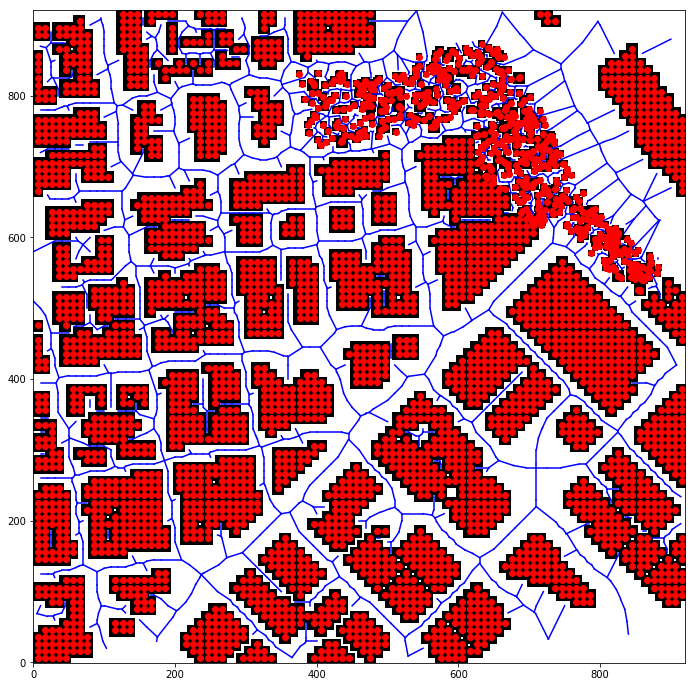

In [11]:
safety_distance = 3
drone_altitude = 5

grid = p.create_grid()

image = grid

fig = plt.figure()
plt.imshow(image, origin='lower', cmap='Greys') 

for p1, p2 in edges:
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], color='blue')
    
d = p.worldmap.data

plt.scatter(d[:, 1] - east_min, d[:, 0] - north_min, color='red')
    
plt.show()

# Voronoi (World Coordinate -ve)

-316.0
-445.0


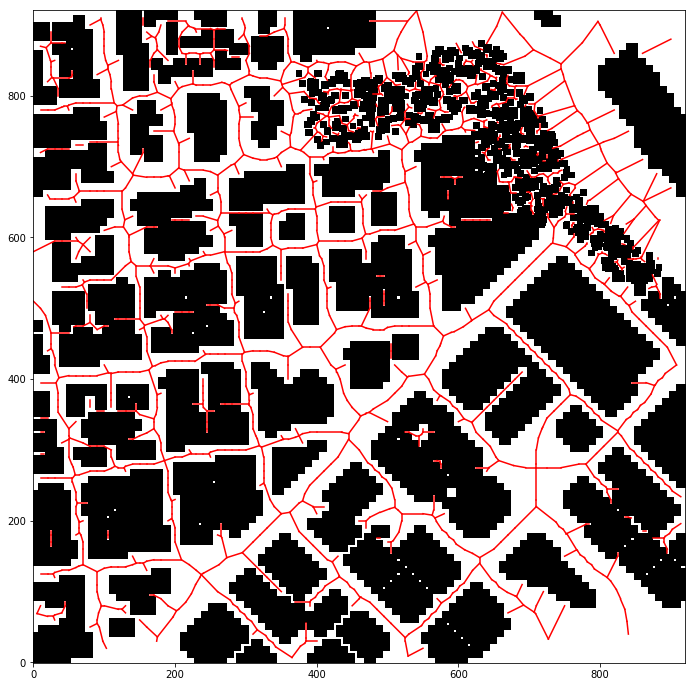

In [12]:
print(north_min)
print(east_min)
e_w = []

for p1, p2 in edges:
    p1_w = (p1[0] + north_min, p1[1] + east_min)
    p2_w = (p2[0] + north_min, p2[1] + east_min)
    e_w.append((p1_w, p2_w))

fig = plt.figure()
plt.imshow(grid, origin='lower', cmap='Greys') 

for p1, p2 in e_w:
    p1_i = p1[0] - north_min, p1[1] - east_min
    p2_i = p2[0] - north_min, p2[1] - east_min
    plt.plot([p1_i[1], p2_i[1]], [p1_i[0], p2_i[0]], color='red')

In [17]:
import networkx as nx
from sklearn.neighbors import KDTree

g = nx.Graph()
for p1, p2 in e_w:
    g.add_edge(tuple(p1), tuple(p2))

print('Edges: ', len(g.edges))
print('Nodes: ', len(g.nodes))

t = KDTree(g.nodes)

Edges:  1886
Nodes:  1822


-316.0


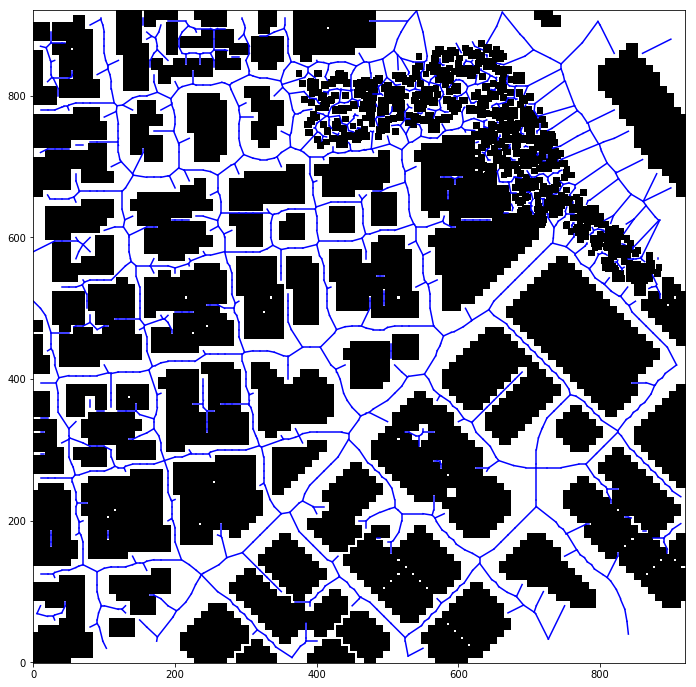

In [62]:
fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')

print(north_min)

for (n1, n2) in g.edges:
    n1_i = (n1[0] - north_min, n1[1] - east_min)
    n2_i = (n2[0] - north_min, n2[1] - east_min)
    
    plt.plot([n1_i[1], n2_i[1]], [n1_i[0], n2_i[0]], color='blue')

plt.show()

In [ ]:
edges = planner.get_voronoi_edges()
print(len(edges))

fig = plt.figure()

grid = planner.get_grid()
plt.imshow(grid, origin='lower', cmap='Greys') 

plt.show()

In [ ]:
edges = self.get_voronoi_edges()

self.graph = nx.Graph()
for p1, p2 in edges:
    self.graph.add_edge(tuple(p1), tuple(p2))

return self.graph
